In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Dense,Flatten
from tensorflow.keras.optimizers import Adagrad
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img,array_to_img, ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import cv2


In [2]:
IMAGE_SIZE = [128, 128]

train_path = 'imageset/train'
valid_path = 'imageset/val'
test_path = 'imageset/test'


# Using weights from imagenet for ResNet model 

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50

# add preprocessing layer to the front of VGG
vgg = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't trains existing weights
for layer in vgg.layers:
  layer.trainable = False

In [7]:
folders = glob('imageset/train/*/*')

In [8]:
COUNT_benign = len([filename for filename in folders if "benign" in filename])
print("benign images count in training set: " + str(COUNT_benign))

COUNT_malignant = len([filename for filename in folders if "malignant" in filename])
print("malignant images count in training set: " + str(COUNT_malignant))

benign images count in training set: 4800
malignant images count in training set: 4876


The dataset is balanced so no data Argumentation needed.

In [9]:
  
# our layers - you can add more if you want
x = Flatten()(vgg.output)
#x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
#Model training and creation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('imageset/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('imageset/val',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_vgg16.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):  #
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


# fit the model
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Found 9676 images belonging to 2 classes.
Found 2628 images belonging to 2 classes.


C:\Users\dhand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
303/303 [==============================] - 1742s 6s/step - loss: 1.1753 - accuracy: 0.5981 - val_loss: 0.4510 - val_accuracy: 0.8394
Epoch 2/5
303/303 [==============================] - 1252s 4s/step - loss: 0.4911 - accuracy: 0.7575 - val_loss: 0.5011 - val_accuracy: 0.7131
Epoch 3/5
303/303 [==============================] - 1214s 4s/step - loss: 0.4911 - accuracy: 0.7722 - val_loss: 0.6766 - val_accuracy: 0.6279
Epoch 4/5
303/303 [==============================] - 1242s 4s/step - loss: 0.3599 - accuracy: 0.8412 - val_loss: 0.2366 - val_accuracy: 0.9273
Epoch 5/5
303/303 [==============================] - 1288s 4s/step - loss: 0.2638 - accuracy: 0.9023 - val_loss: 0.2194 - val_accuracy: 0.9338


In [12]:
#saving the model created
import tensorflow as tf
from tensorflow.keras.models import load_model
model.save('model_incepresnet.h5')


TESTING

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('model_incepresnet.h5')

In [14]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=20)
    #class_mode='binary')

Found 1942 images belonging to 2 classes.


In [15]:
# finally evaluate this model on the test data
results = model.evaluate_generator(
    test_generator,
    steps=1000)

C:\Users\dhand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [16]:
print('Final test accuracy:', (results[1]*100.0))

Final test accuracy: 93.61482858657837


In [17]:
print(r.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


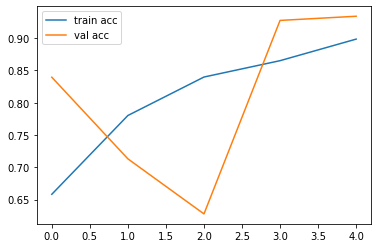

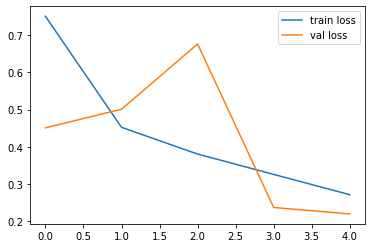

<Figure size 432x288 with 0 Axes>

In [18]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.savefig('AccVal_acc')

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


In [19]:
from sklearn.metrics import classification_report, confusion_matrix



#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['benign', 'malignant']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

C:\Users\dhand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[1284  317]
 [ 265   76]]
Classification Report
              precision    recall  f1-score   support

      benign       0.83      0.80      0.82      1601
   malignant       0.19      0.22      0.21       341

    accuracy                           0.70      1942
   macro avg       0.51      0.51      0.51      1942
weighted avg       0.72      0.70      0.71      1942



In [27]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(test_generator.classes, y_pred)

total1=sum(sum(cm1))


sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

# mcc = (cm1[0,0]*cm1[1,1])-(cm1[1,0]*cm1[0,1])
# denom = np.sqrt((cm1[0,0] + cm1[1,0]) * (cm1[0,0] + cm1[0,1]) * (cm1[1,1] + cm1[1,0]) * (cm1[1,1] +cm1[0,1]))
# mcc1 = mcc/denom
# print('MCC:',mcc1*100)

Sensitivity :  0.801998750780762
Specificity :  0.22287390029325513


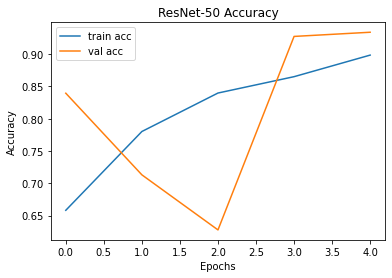

<Figure size 432x288 with 0 Axes>

In [31]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet-50 Accuracy')
plt.show()
plt.savefig('AccVal_acc')





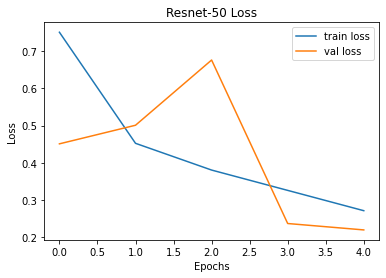

<Figure size 432x288 with 0 Axes>

In [32]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Resnet-50 Loss')
plt.show()
plt.savefig('LossVal_loss')

NameError: name 'test' is not defined

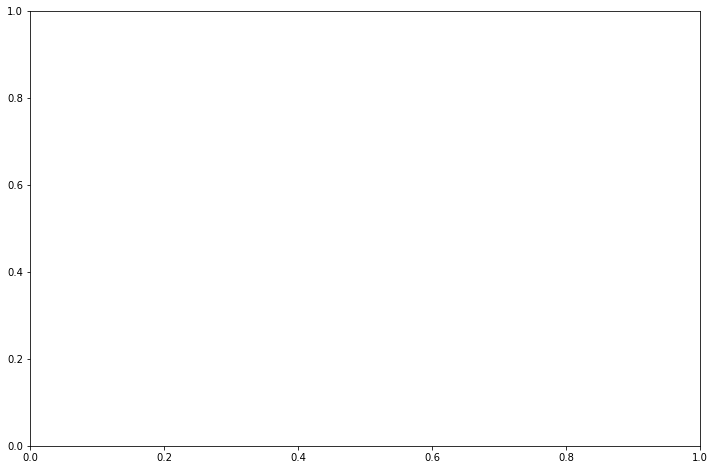

In [36]:
# from sklearn.metrics import classification_report, confusion_matrix



# #Confution Matrix and Classification Report
# Y_pred = model.predict_generator(test, len(test))
# y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(test.classes, y_pred))
# print('Classification Report')
# target_names = ['benign', 'malignant']
# print(classification_report(test.classes, y_pred, target_names=target_names))


#To plot a ROC curve and AUC score for multi-class classification:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
#valid_generator.reset() # resetting generator
y_pred = model.predict_generator(test,len(test), verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test.classes, y_pred)

In [1]:
!pip install tensorflow-gpu==2.4

  Using cached grpcio-1.32.0-cp38-cp38-win_amd64.whl (2.6 MB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
-ensorflow-gpu 2.2.0rc2 requires tensorboard<2.3.0,>=2.2.0, but you have tensorboard 2.7.0 which is incompatible.
tensorflow 2.5.0 requires gast==0.4.0, but you have gast 0.3.3 which is incompatible.
tensorflow 2.5.0 requires grpcio~=1.34.0, but you have grpcio 1.32.0 which is incompatible.
tensorflow 2.5.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.
tensorflow 2.5.0 requires tensorflow-estimator<2.6.0,>=2.5.0rc0, but you have tensorflow-estimator 2.4.0 which is incompatible.



  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.36.1
    Uninstalling grpcio-1.36.1:
      Successfully uninstalled grpcio-1.36.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 2.7.0
    Uninstalling tensorflow-gpu-2.7.0:
      Successfully uninstalled tensorflow-gpu-2.7.0


In [29]:
def compute_mcc(true_labels, pred_labels):
    """Compute matthew's correlation coefficient.

    :param true_labels: 2D integer array (features x samples)
    :param pred_labels: 2D integer array (features x samples)
    :return: mcc (samples1 x samples2)
    """
    # prep inputs for confusion matrix calculations
    pred_labels_1 = pred_labels == 1; pred_labels_0 = pred_labels == 0
    true_labels_1 = true_labels == 1; true_labels_0 = true_labels == 0
    
    # dot product of binary matrices
    confusion_dot = lambda a,b: np.dot(a.T.astype(int), b.astype(int)).T
    TP = confusion_dot(pred_labels_1, true_labels_1)
    TN = confusion_dot(pred_labels_0, true_labels_0)
    FP = confusion_dot(pred_labels_1, true_labels_0)
    FN = confusion_dot(pred_labels_0, true_labels_1)

    mcc = (TP * TN) - (FP * FN)
    denom = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    
    # avoid dividing by 0
    denom[denom == 0] = 1

    return mcc / denom

In [30]:

compute_mcc(test_generator.classes, y_pred)

<ipython-input-29-f8e7bdaeeb69>:20: RuntimeWarning: overflow encountered in long_scalars
  denom = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
<ipython-input-29-f8e7bdaeeb69>:20: RuntimeWarning: invalid value encountered in sqrt
  denom = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))


TypeError: 'numpy.float64' object does not support item assignment

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
